In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import datetime

# Configuration
STOCK_TICKER = "AAPL"  # Example: Apple Inc. You can change this to TCS, INFY, etc.
START_DATE = "2020-01-01"
END_DATE = datetime.date.today().strftime("%Y-%m-%d") # Today's date



In [5]:
# 1. Data Acquisition 
def get_stock_data(ticker, start, end):
    
    print(f"Downloading data for {ticker} from {start} to {end}...")
    try:
        data = yf.download(ticker, start=start, end=end)
        if data.empty:
            print(f"No data found for {ticker} in the specified range. Please check the ticker or dates.")
            return None
        print("Data downloaded successfully.")
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None



In [6]:
# 2. Data Preprocessing
def preprocess_data(df):
    print("Starting data preprocessing...")

    # Drop any rows with missing values (though yfinance data is usually clean)
    initial_rows = df.shape[0]
    df.dropna(inplace=True)
    if df.shape[0] < initial_rows:
        print(f"Dropped {initial_rows - df.shape[0]} rows due to missing values.")

    # Feature Engineering: Create relevant features
    df['Day_of_Week'] = df.index.dayofweek
    df['Day_of_Year'] = df.index.dayofyear
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Lagged features (previous day's Close, Volume, etc.)
    df['Prev_Close'] = df['Close'].shift(1)
    df['Prev_Volume'] = df['Volume'].shift(1)
    df['Prev_High'] = df['High'].shift(1)
    df['Prev_Low'] = df['Low'].shift(1)

    # Moving Averages (e.g., 5-day and 20-day Simple Moving Average)
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()

    # Volatility (e.g., standard deviation of returns)
    df['Daily_Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Daily_Return'].rolling(window=5).std()

    # Drop rows with NaN values introduced by shifting or rolling operations
    df.dropna(inplace=True)
    print(f"Data after feature engineering and dropping NaNs: {df.shape[0]} rows.")

    # Define features (X) and target (y)
    # We want to predict 'Close' price
    features = ['Open', 'High', 'Low', 'Volume', 'Day_of_Week', 'Day_of_Year',
                'Month', 'Year', 'Prev_Close', 'Prev_Volume', 'Prev_High',
                'Prev_Low', 'SMA_5', 'SMA_20', 'Volatility']
    target = 'Close'

    X = df[features]
    y = df[target]

    # Scaling features and target
    # It's crucial to scale X and y separately, especially y,
    # because we need to inverse transform y_pred later.
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)) # Reshape for scaler

    X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)
    y_scaled_df = pd.DataFrame(y_scaled, columns=[target], index=y.index)

    print("Data preprocessing complete.")
    return X_scaled_df, y_scaled_df, feature_scaler, target_scaler



In [7]:
# 3. Model Implementation and Evaluation
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, target_scaler, model_name):
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train.values.ravel()) # .ravel() for 1D array expected by scikit-learn models

    # Make predictions on the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform the scaled predictions and actual values to original scale
    y_test_actual = target_scaler.inverse_transform(y_test)
    y_pred_actual = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # Evaluate the model
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred_actual)

    print(f"{model_name} Performance:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  R-squared (R2): {r2:.4f}")

    return y_test_actual, y_pred_actual



In [8]:
# 4. Visualization
def plot_predictions(actual_prices, predicted_prices, dates, model_name, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual_prices, label='Actual Prices', color='blue')
    plt.plot(dates, predicted_prices, label='Predicted Prices', color='red', linestyle='--')
    plt.title(f'{ticker} Stock Price Prediction - {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



/tmp/ipykernel_454/235519698.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Data downloaded successfully.
Starting data preprocessing...
Data after feature engineering and dropping NaNs: 1367 rows.
Data preprocessing complete.

Training data size: 1093 samples
Test data size: 274 samples

--- Training Linear Regression ---
Linear Regression Performance:
  Mean Squared Error (MSE): 2.2001
  Root Mean Squared Error (RMSE): 1.4833
  R-squared (R2): 0.9910


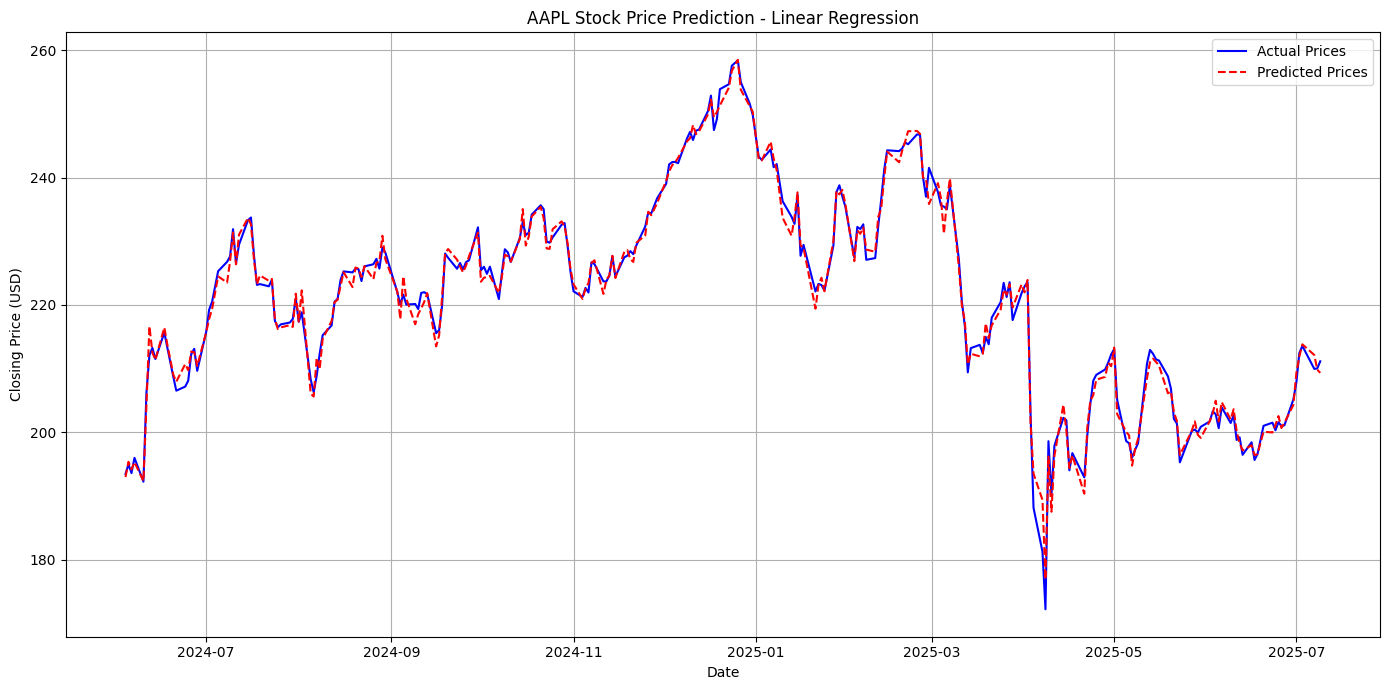


--- Training Random Forest Regressor ---
Random Forest Regressor Performance:
  Mean Squared Error (MSE): 896.2710
  Root Mean Squared Error (RMSE): 29.9378
  R-squared (R2): -2.6511


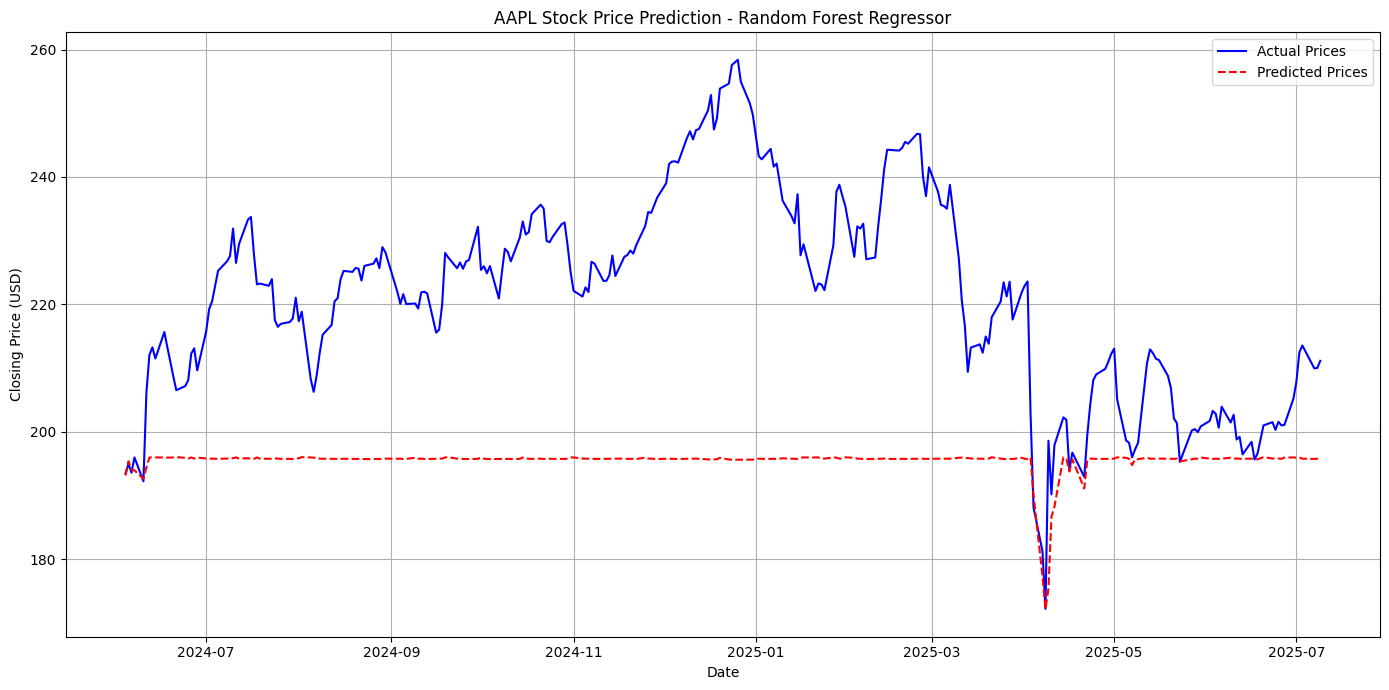


Project execution complete.


In [9]:
# 5. Main Execution
if __name__ == "__main__":
    # Get data
    stock_df = get_stock_data(STOCK_TICKER, START_DATE, END_DATE)

    if stock_df is not None:
        # Preprocess data
        X_scaled, y_scaled, feature_scaler, target_scaler = preprocess_data(stock_df.copy())

        # Split data into training and testing sets
        # We use a time-based split for time series data to avoid data leakage.
        # Typically, 80% for training, 20% for testing.
        train_size = int(len(X_scaled) * 0.8)
        X_train, X_test = X_scaled[0:train_size], X_scaled[train_size:len(X_scaled)]
        y_train, y_test = y_scaled[0:train_size], y_scaled[train_size:len(y_scaled)]

        # Get the dates for the test set for plotting
        test_dates = X_test.index

        print(f"\nTraining data size: {len(X_train)} samples")
        print(f"Test data size: {len(X_test)} samples")

        # Linear Regression Model 
        lr_model = LinearRegression()
        actual_lr, predicted_lr = train_and_evaluate_model(
            lr_model, X_train, y_train, X_test, y_test, target_scaler, "Linear Regression"
        )
        plot_predictions(actual_lr, predicted_lr, test_dates, "Linear Regression", STOCK_TICKER)

        # Random Forest Regressor Model
        # RandomForest generally performs better for such tasks due to its ensemble nature
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        actual_rf, predicted_rf = train_and_evaluate_model(
            rf_model, X_train, y_train, X_test, y_test, target_scaler, "Random Forest Regressor"
        )
        plot_predictions(actual_rf, predicted_rf, test_dates, "Random Forest Regressor", STOCK_TICKER)

    print("\nProject execution complete.")
